In [4]:
# import the necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram,linkage
from sklearn.cluster import AgglomerativeClustering

In [5]:
# read the csv file
df = pd.read_csv('../../data/hate_speech.csv',index_col=0)
# only use the numerical data
df = df.loc[:,['id','follower_count','friends_count','retweet_count','favorite_count','word_length','label']]
df.rename({'id':'timestamp'},axis=1,inplace=True)
df.head(5)

,timestamp,follower_count,friends_count,retweet_count,favorite_count,word_length,label
0,930620467,19820,258,19,17,11,0
1,13857342,19172,797,0,2,8,0
2,482583016,59,39,0,3,10,0
3,930620467,19820,258,1,0,11,0
4,13857342,19170,797,0,1,8,0


In [6]:
x = df.drop(columns='label')
y = df.label
model = StandardScaler()
x_scaled = model.fit_transform(x)

In [7]:
pca = PCA(n_components = 2)
X_principal = pca.fit_transform(x_scaled)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1', 'P2']

In [8]:
x = X_principal.values

In [9]:
# for k means clustering we will use the elbow method to find the optimal number of clusters. we will use the inertia_ attribute to find the sum of squared distances of samples to their closest cluster center. we will use the range of 1 to 10 clusters. plot the inertia_ values for each number of clusters. make sure to save it in a dataframe and plot it using matplotlib.
kmeans_kwargs = {
    "init":"k-means++",
    "random_state":42
}
sse = []
distortions = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,**kmeans_kwargs)
    kmeans.fit(x)
    sse.append(kmeans.inertia_)
    distortions.append(sum(np.min(cdist(x, kmeans.cluster_centers_,
                                        'euclidean'), axis=1)) / x.shape[0])
evaluation = pd.DataFrame.from_records({'cluster':np.arange(1,i+1),'Inertia':sse,'distortions':distortions})
evaluation

,Inertia,cluster,distortions
0,3765.685203,1,1.100073
1,2673.048992,2,0.980413
2,1794.916607,3,0.718817
3,1116.255813,4,0.677561
4,830.868650,5,0.487408
5,551.934646,6,0.471759
6,358.374516,7,0.418643
7,260.926600,8,0.366719
8,220.097063,9,0.327618
9,188.937529,10,0.317215


array([<AxesSubplot:xlabel='cluster'>, <AxesSubplot:xlabel='cluster'>],
      dtype=object)

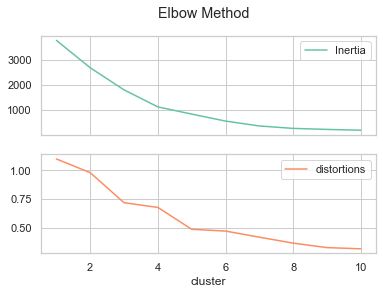

In [19]:
evaluation.plot.line(x = 'cluster',subplots=True,title='Elbow Method')

In [11]:
X_principal.loc[:,'label'] = df.label

<AxesSubplot:xlabel='P1', ylabel='P2'>

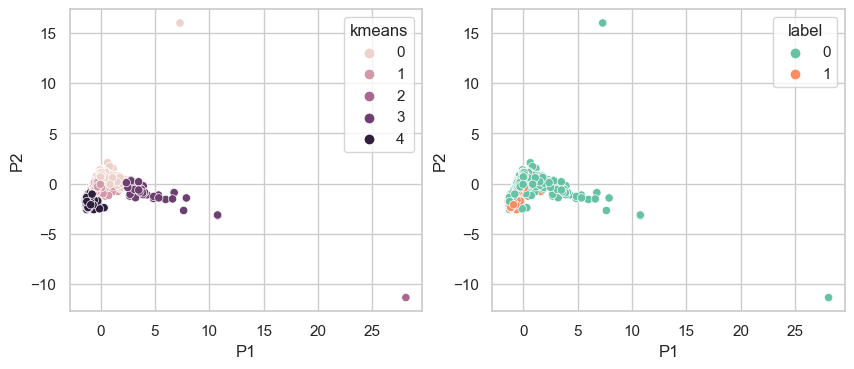

In [12]:
sns.set_theme(style='whitegrid',palette='Set2')
bestk = KMeans(n_clusters=5,**kmeans_kwargs)
kmeans = bestk.fit_predict(x)
X_principal.loc[:,'kmeans'] = kmeans
fig,axes = plt.subplots(1,2,figsize=(10,4),dpi=100)
sns.scatterplot(X_principal,x='P1',y='P2',hue='kmeans',ax=axes[0])
sns.scatterplot(X_principal,x='P1',y='P2',hue ='label', ax=axes[1])


In [16]:
epsilon = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.25,1.5,1.75, 2,2.25,2.5,2.75, 3,3.25,3.5,3.75, 4]
min_samples = [10,15,20,25]


sil_avg = []
max_value = [0,0,0,0]

for i in range(len(epsilon)):
    for j in range(len(min_samples)):

        db = DBSCAN(min_samples = min_samples[j], eps =epsilon[i]).fit(x)
        #cluster_labels=dbscan.fit_predict(data) 
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)


        silhouette_avg = silhouette_score(x, labels)
        if silhouette_avg > max_value[3]:
            max_value=(epsilon[i], min_samples[j], n_clusters_, silhouette_avg)
        sil_avg.append(silhouette_avg)

print("epsilon=", max_value[0], 
      "\nmin_sample=", max_value[1],
      "\nnumber of clusters=", max_value[2],
      "\naverage silhouette score= %.4f" % max_value[3])

epsilon= 3.25 
min_sample= 10 
number of clusters= 1 
average silhouette score= 0.9338


<AxesSubplot:xlabel='P1', ylabel='P2'>

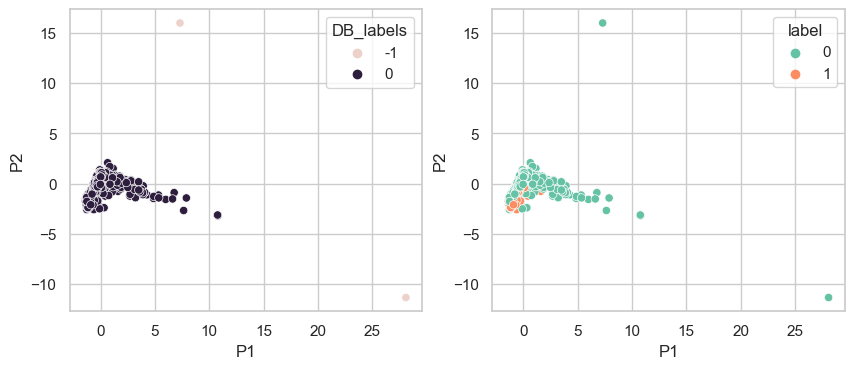

In [17]:
# DBSCAN density clustering method
# perform DBSCAN clustering. use the eps and min_samples parameters to find the optimal number of clusters. plot the number of clusters vs the silhouette score. Suggest the optimal number of clusters based on the plot.
DB = DBSCAN(eps=3.25,min_samples=10).fit(x)
DB_labels = DB.labels_
X_principal.loc[:,'DB_labels'] = DB_labels
fig,axes = plt.subplots(1,2,figsize=(10,4),dpi=100)
sns.scatterplot(X_principal,x='P1',y='P2',hue='DB_labels',ax=axes[0])
sns.scatterplot(X_principal,x='P1',y='P2',hue ='label', ax=axes[1])


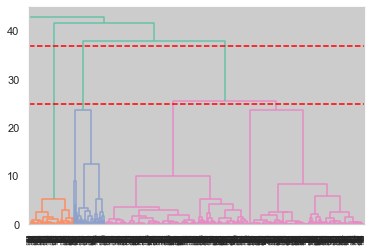

In [ ]:
tree = dendrogram(linkage(x, method='ward'))
plt.axhline(y=25.5,color = 'r',linestyle='--',linewidth=2)
plt.axhline(y=38,color = 'r',linestyle='--',linewidth=2)

<AxesSubplot:xlabel='P1', ylabel='P2'>

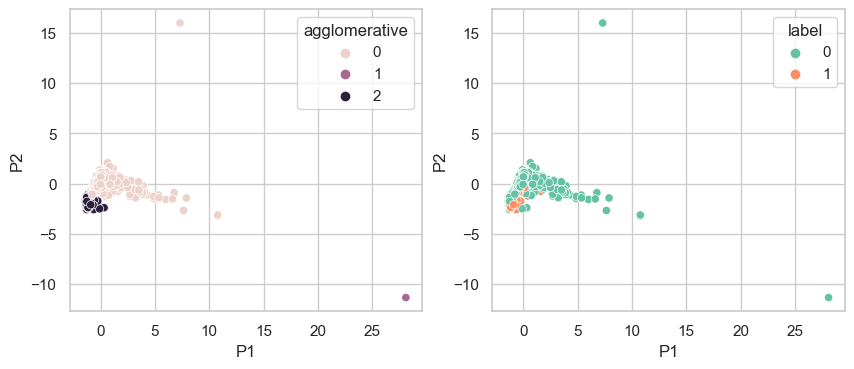

In [ ]:
agg = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
agg.fit(x)
labels = agg.labels_
X_principal.loc[:,'agglomerative'] = labels
fig,axes = plt.subplots(1,2,figsize=(10,4),dpi=100)
sns.scatterplot(X_principal,x='P1',y='P2',hue='agglomerative',ax=axes[0])
sns.scatterplot(X_principal,x='P1',y='P2',hue ='label', ax=axes[1])